# Introduction to non-smooth problems and proximal methods 

## Non-smooth convex optimization problem

$$
\min_{x \in \mathbb{R}^n} f(x),
$$

where $f(x)$ is convex, but **non-smooth**.

**Q:** since gradient does not exist, what method can solve

such problem? 

## Subgradient method

- Replace gradient with subgradient 
- Original book is [Minimization methods for non-differentiable functions](http://cds.cern.ch/record/104965) by [Naum Shor](https://ru.wikipedia.org/wiki/%D0%A8%D0%BE%D1%80,_%D0%9D%D0%B0%D1%83%D0%BC_%D0%97%D1%83%D1%81%D0%B5%D0%BB%D0%B5%D0%B2%D0%B8%D1%87)
- Good review in old-school style is [here](https://core.ac.uk/download/pdf/33892291.pdf#page=15)
- Compare the method with gradient descent

### Non-descent method

- Example

$$
f(x_1, x_2) = |x_1| + 2|x_2|
$$

- At $x = (1, 0)$ a subgradient is $(1, 2)$
- The direction $-g$ is not descent

## Any good news?

- Let us estimate convergence of the subgradient method 
- $\|x_{k+1} - x^*\|^2_2 = \|x_k - \alpha_k g_k - x^*\|_2^2 \leq \|x_k - x^*\|^2_2 - 2\alpha_k g^{\top}_k(x_k - x^*) + \alpha^2_k \|g_k\|_2^2 \leq \|x_k - x^*\|^2_2 - 2\alpha_k (f(x_k) - f^*) + \alpha^2_k \|g\|_2^2$
- Use the minimum function value after $k$ iterations $f_{best}^{(k)}$

$$
2 \left(\sum_{i=1}^k \alpha_i\right) (f^{(k)}_{best} - f^*) \leq \| x_0 - x^*\|_2^2 - \|x_k - x^* \|_2^2 + \sum_{i=1}^k \alpha^2_i \|g_i\|_2^2 \leq \| x_0 - x^*\|_2^2 + \sum_{i=1}^k \alpha^2_i \|g_i\|_2^2
$$

- Finally

$$
f^{(k)}_{best} - f^* \leq \frac{\| x_0 - x^*\|_2^2 + \sum_{i=1}^k \alpha^2_i \|g_i\|_2^2}{2\sum_{i=1}^k \alpha_i}
$$

## Step size selection

- Fix step size $\alpha$

$$
f^{(k)}_{best} - f^* \leq \frac{\| x_0 - x^*\|_2^2 + G^2 k \alpha^2}{2 k \alpha} = \frac{\| x_0 - x^*\|_2^2}{2 k \alpha} + \frac{G^2 \alpha}{2},
$$

where $\|g_i\|_2 \leq G$

- Scaled gradient norm $\alpha_i = \frac{s}{\|g_{i}\|_2}$

$$
f^{(k)}_{best} - f^* \leq \frac{G\| x_0 - x^*\|_2^2}{2 k s} + \frac{G s}{2},
$$

- Diminishing step size: $\alpha_i \to 0, \sum_{i=1}^{\infty}\alpha_i = \infty$

$$
f^{(k)}_{best} - f^* \to 0. \quad k \to \infty
$$

## Test problem

$$
\|Ax - b\|_1 \to \min_x
$$

In [21]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

USE_COLAB = False
if not USE_COLAB:
    plt.rc("text", usetex=True)

if USE_COLAB:
    !pip install git+https://github.com/amkatrutsa/liboptpy
        
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss


m, n = 500, 100
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A.dot(x_true)

In [23]:
f = lambda x: np.linalg.norm(A.dot(x) - b, 1)
subgrad = lambda x: A.T.dot(np.sign(A.dot(x) - b))
alpha = 1e-3
s = 1e-1
sg_methods = {
    "SM 1/k": methods.fo.SubgradientMethod(f, subgrad, ss.InvIterStepSize()),
    "SM fixed={}".format(alpha): methods.fo.SubgradientMethod(f, subgrad, ss.ConstantStepSize(alpha)),
    "SM scaled fix, s={}".format(s): methods.fo.SubgradientMethod(f, subgrad, 
                                                  ss.ScaledConstantStepSize(s)),
}

In [24]:
x0 = np.random.randn(n)
max_iter = 6000

In [29]:
for m in sg_methods:
    _ = sg_methods[m].solve(x0=x0, max_iter=10 * max_iter)

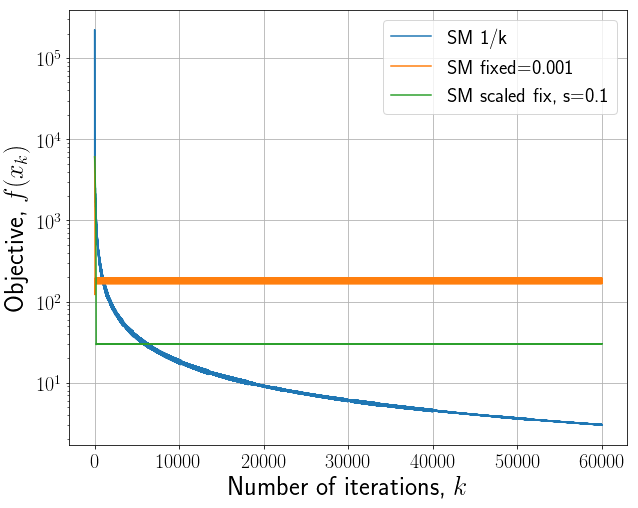

In [30]:
plt.figure(figsize=(10, 8))
for m in sg_methods:
    plt.semilogy([f(x) for x in sg_methods[m].get_convergence()], label=m)
plt.legend(fontsize=20)
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Objective, $f(x_k)$", fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

In [31]:
import cvxpy as cvx
x = cvx.Variable(n)
problem = cvx.Problem(cvx.Minimize(cvx.norm1(A * x - b)))
problem.solve(solver=cvx.SCS, verbose=True)

----------------------------------------------------------------------------
	SCS v2.1.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 101000
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 600, constraints m = 1000
Cones:	linear vars: 1000
Setup time: 2.87e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.26e+19  9.91e+19  1.00e+00 -2.84e+23  4.31e+18  1.83e+23  3.82e-03 
     8| 1.79e-12  2.02e-11  4.39e-09 -2.02e-12 -4.39e-09  3.27e-14  9.99e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.00e-02s

-2.016460386281147e-12

## Summary on subgradient method

- Black-box method for non-smooth function
- Natural generalization of gradient descent
- But it is not descent method :(
- Step size selection rules

## Gradient descent as forward Euler scheme

Consider the following ODE

$$
\frac{dx}{dt} = -f'(x(t))
$$

and after discretization

$$
\frac{x_{k+1} - x_k}{\alpha} = -f'(x_k),
$$

where $\alpha = t_{k+1} - t_k$ is a grid step and $x_k \equiv x(t_k)$

From this follows 

$$
x_{k+1} = x_k - \alpha f'(x_k),
$$

which is equivalent to gradient descent method

### Properties of forward Euler scheme

- Easy to use
- Can be unstable if $\alpha$ is too large, which is natural drawback of gradient descent with large step size
- Stability issue can be solved with **backward Euler scheme**

## Proximal method as backward Euler scheme

$$
\frac{dx}{dt} = -f'(x(t))
$$

and after discretization in backward manner

$$
\frac{x_{k+1} - x_k}{\alpha} = -f'({\color{red}{x_{k+1}}}),
$$

After some re-arrangements

\begin{align*}
& \left(\frac{1}{2\alpha} \|u - x_k\|_2^2 + f(u) \right)'(x_{k+1}) = 0 \\
& x_{k+1} = \arg\min_u \left(f(u) + \frac{1}{2\alpha} \|u - x_k\|_2^2\right) = prox_{\alpha f}(x_k)
\end{align*}



### Example: iterative refinement

The method to solve positive semi-definite linear system given Cholesky factorization of $A + \epsilon I$ for some $\epsilon$
$$
f(x) = \frac{1}{2}x^{\top}Ax - b^{\top}x \to \min_x,
$$
where $A \in \mathbb{S}^n_+$

\begin{align*}
prox_{\alpha f} (x_k) & = \arg\min_u \left(\frac{1}{2}u^{\top}Au - b^{\top}u + \frac{1}{2\alpha} \|u - x_k\|_2^2\right) \\
& = \left(A + (1/ \alpha) I\right)^{-1}\left(b + (1 / \alpha)x_k\right) \\
& = x_k + (A + \epsilon I)^{-1}(b - Ax_k)
\end{align*}


### Properties of proximal map 
$$
x_{k+1} = prox_{f}(x_k)
$$

1. Fixed point of proximal operator is equal to minimizer of $f$

$$
x^* = prox_f(x^*)
$$ 

Proximal map is not a contraction

There exists theory on firm non-expansiveness of proximal operator

2. Resolvent of operator

$$
prox_{\alpha f}(x) = (I + \alpha f')^{-1}(x)
$$

This property can be extended to subdifferential.

### Modified gradient step interpretation

Assume $f$ is twice differentiable and strong convex ($f''(x) \succ 0$).

1. Gradient method as approximation of proximal method

$$
x_{k+1} = prox_{\alpha f} (x_k) = (I + \alpha f')^{-1}(x_k) \approx x_k - \alpha f'(x_k) + o(\alpha), \; \alpha \to 0  
$$

2. Proximal method for second-order approximation $\hat{f}(v) = f(x) + \langle f'(x), v - x \rangle + \frac{1}{2}\langle v - x, f''(x) (v - x) \rangle$

$$
prox_{\alpha \hat{f} }(x_k) = x_k - (f''(x_k) + (1 / \alpha)I)^{-1}f'(x_k) 
$$

### Separable sum

If $f$ has the form

$$
f(x) = \sum_{i=1}^n f_i(x_i),
$$

where $x_i \in \mathbb{R}$ and $x = [x_1, \ldots, x_n]$, then 

$$
prox_f(v)_i = prox_{f_i}(v_i)
$$

- High parallelization of the proximal operator computing 
- **Consensus form** of the problem
$$
\min \sum_{i=1}^n f_i(y) \to \min \sum_{i=1}^n f_i(y_i), \; \text{s.t. } y_1 = \ldots = y_n,
$$

where $y, \ y_i \in \mathbb{R}^n$.

## Proximal gradient method (PGM) - look into black box

Consider convex function $f$ such that

$$
f(x) = h(x) + g(x),
$$

where $h(x)$ is convex differentiable, and $g(x)$ can be convex extended-value function, so $g: \mathbb{R}^n \to \mathbb{R} \cup \{+\infty\}$

Then the one step of the proximal gradient method is

$$
x_{k+1} = prox_{\alpha_k g} (x_k - \alpha_k h'(x_k))
$$

- Convergence rate $\mathcal{O}(1/k)$ for step size $\alpha_k \equiv \alpha \in (0, 1/L]$, where $L$ is Lipschitz constant of $h'$
- Backtracking procedure is available for adaptive search of $\alpha_k$

### Pacticular cases of PGM

- If $h \equiv 0$, then PGM is simple proximal method
- If $g \equiv 0$, then PGM is vanilla gradient descent method
- If $g$ is an indicatir function for convex closed set $G$, then PGM is gradient projection method

### Fixed point iteration interpretation

From the first-order optimality condition follows

\begin{align*}
& 0 \in \alpha h'(x^*) + \alpha\partial g(x^*)\\
& 0 \in \alpha h'(x^*) + x^* - x^* + \alpha\partial g(x^*)\\
& (I - \alpha h')(x^*) \in (I + \alpha \partial g)(x^*)\\
& x^* = (I + \alpha \partial g)^{-1}(I - \alpha h')(x^*)\\
& x^* = prox_{\alpha g}(x^* - \alpha h'(x^*))
\end{align*}

## Accelerated proximal gradient method

\begin{align*}
& y_{k+1} = x_k + w_k (x_k - x_{k+1})\\
& x_{k+1} = prox_{\alpha_k g} (y_{k+1} - \alpha_k h'(y_{k+1}))
\end{align*}

- $\{w_k\}$ is special sequence that has to be chosen to accelerate convergence, for example $w_k = \frac{k}{k+3}$
- Similar backtracking procedure is helpful for adaptive search $\alpha_k$
- Convergence rate $\mathcal{O}(1/k^2)$ which is tight lower bound for convex function

## Lasso example

$$
\min_x \frac{1}{2}\|Ax - y \|^2_2 + \gamma \|x\|_1
$$

- $h(x) = \frac{1}{2}\|Ax - y \|^2_2$
- $g(x) = \gamma \|x\|_1$

####  Soft thresholding

- $\|x\|_1 = |x_1| + \ldots + |x_n|$
- Separable sum
- $prox_{\alpha \|x\|_1} (x)_i = prox_{\alpha |\cdot|}(x_i)$
- $prox_{\alpha |\cdot|} (x_i) = \arg\min_u (|u| + 1/(2\alpha)(u - x_i)^2)$
- Analytical solution
$$ 
prox_{\alpha |\cdot|} (x_i) = \begin{cases} x_i - \alpha & x_i \geq \alpha  \\ 0 & |x_i| \leq \alpha \\ x_i + \alpha & x_i \leq -\alpha \end{cases}
$$
- Vectorized form
$$
prox_{\alpha \|x\|_1} (x) = \text{sign}(x)(|x| - \alpha)_+, \; |x| = (|x_1|, \ldots, |x_n|)
$$

####  (F)ISTA

- Proximal gradient method for Lasso problem is known as ISTA (Iterative shrinkage-thresholding algorithm)
- Fast proximal gradient is known as FISTA (Fast ISTA)

### Experiments

In [1]:
def prox_alg(f, f_grad, g_prox, x0, num_iter, beta=0.5, fix_lam=None, accel=False):
    conv = [x0]
    x = x0.copy()
    if accel:
        t_prev = 1
        t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
    if fix_lam is None:
        lam = 1.
    for i in range(num_iter):
        if accel and i > 0:
            x = x + (t_prev - 1) / t_next * (x - conv[-2])
            t_prev = t_next
            t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
        if fix_lam is None:
            while True:
                z = g_prox(x - lam * f_grad(x), lam)
                if f(z) <= f(x) + f_grad(x).dot(z - x) + np.linalg.norm(z - x)**2 / (2 * lam):
                    break
                else:
                    lam = lam * beta
        else:
            z = g_prox(x - fix_lam * f_grad(x), fix_lam)
        x = z.copy()
        conv.append(x)
    return x, conv

In [16]:
import sklearn.preprocessing as skprep
import numpy as np
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
import matplotlib.pyplot as plt

m = 500
n = 2500
A = np.random.rand(m, n)
A = skprep.normalize(A, norm="l2", axis=0)
L = np.linalg.eigvalsh(A.T.dot(A)).max()
x_true = np.random.randn(n)
x_true[np.random.rand(n) < 0.96] = 0
print("Number of nonzeros in x_true = {}".format(np.sum(x_true != 0)))
v = 9e-2 * np.random.randn(m)
y = A.dot(x_true) + v
gamma_max = np.linalg.norm(A.T.dot(y), ord=np.inf)
gamma = 0.1 * gamma_max
print("Gamma = {}".format(gamma))
print("S2N ratio = {}".format(np.linalg.norm(A.dot(x_true))**2 / np.linalg.norm(v)**2))
f_star = f(x_true) + gamma*np.linalg.norm(x_true, 1)

Number of nonzeros in x_true = 108
Gamma = 0.20873954097988812
S2N ratio = 7.026469364113733


In [17]:

f = lambda x: np.linalg.norm(A.dot(x) - y)**2 / 2
f_grad = lambda x: A.T.dot(A.dot(x) - y)
f_subgrad = lambda x: A.T.dot(A.dot(x) - y) + gamma * np.sign(x)

def g_prox(h, lam):
    return np.sign(h) * np.maximum(np.abs(h) - lam * gamma, 0) 

In [27]:
num_iter = 5000
# x0 = np.zeros(n)
x0 = np.random.rand(n)

In [28]:
x, conv = prox_alg(f, f_grad, g_prox, x0, num_iter, fix_lam=None)
print("Number nonzeros in x* = {}".format(np.sum(x != 0)))
print("f* = {}".format(f(x) + gamma * np.linalg.norm(x, 1)))
x_acc, conv_acc = prox_alg(f, f_grad, g_prox, x0, num_iter, fix_lam=None, accel=True)
print("Number nonzeros in x* = {}".format(np.sum(x_acc != 0)))
print("f* = {}".format(f(x_acc) + gamma * np.linalg.norm(x_acc, 1)))

Number nonzeros in x* = 351
f* = 15.138095829183488
Number nonzeros in x* = 52
f* = 11.618698091088383


In [29]:
subgrad_m = methods.fo.SubgradientMethod(lambda x: f(x) + gamma * np.linalg.norm(x, 1),
                                         f_subgrad, ss.ConstantStepSize(1e-3))
x_subgrad = subgrad_m.solve(x0=x0, max_iter=num_iter)
print("f^* = {}".format(f(x_subgrad) + gamma * np.linalg.norm(x, 1)))
print("Number nonzeros in x* = {}".format(np.sum(x_acc != 0)))

f^* = 17.523804410441947
Number nonzeros in x* = 52


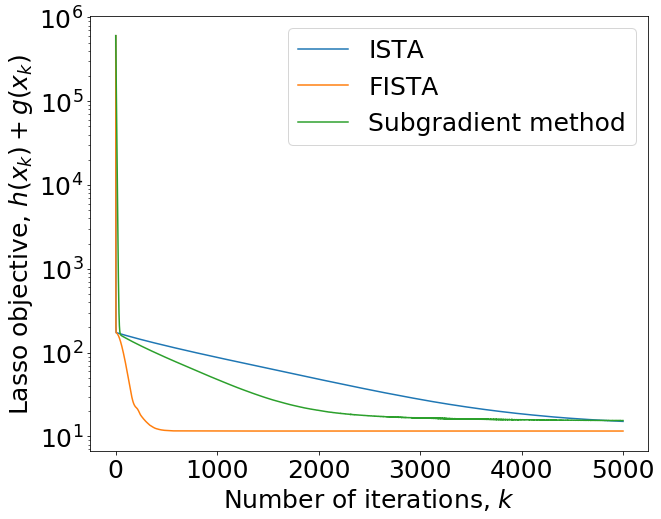

In [30]:
plt.figure(figsize=(10, 8))
fontsize=25
plt.plot([f(x) + gamma * np.linalg.norm(x, 1) for x in conv], label="ISTA")
plt.plot([f(x) + gamma * np.linalg.norm(x, 1) for x in conv_acc], label="FISTA")
plt.plot([f(x) + gamma * np.linalg.norm(x, 1) for x in subgrad_m.get_convergence()], label="Subgradient method")
plt.legend(fontsize=fontsize)
plt.xlabel(r"Number of iterations, $k$", fontsize=fontsize)
plt.ylabel(r"Lasso objective, $h(x_k) + g(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.yscale("log")

## Matrix decomposition

\begin{align*}
& \min \phi_1(X_1) + \gamma_2 \phi_2(X_2) + \ldots + \gamma_N \phi_N(X_N) \\
\text{s.t. } & X_1 + \ldots + X_N = A
\end{align*}

- Decompose matrix in the sum of well-structured matrices
- [Robust PCA](https://statweb.stanford.edu/~candes/papers/RobustPCA.pdf): $A = L + S$, where 
    - $L$ is low-rank
    - $S$ is sparse
    
Good presentation about robust PCA is [here](http://www.princeton.edu/~yc5/ele538b_sparsity/lectures/robust_PCA.pdf)

### Some penalties and structures being induced by them (more details [here](https://www.di.ens.fr/~fbach/opt_book.pdf))

- Squared Frobenius norm gives small entries of $X$

$$
\phi(X) = \sum_{i,j} X^2_{ij}
$$

- Entrywise $\ell_1$ norm leads to sparsity of $X$

$$
\phi(X) = \sum_{i,j} |X_{ij}|
$$

- Nuclear norm gives low-rank matrix $X$ 

$$
\phi(X) = \|X\|_* = \sum_{i=1}^n \sigma_i(X)
$$

In [14]:
import copy

def prox_alg_mat(f, f_grad, g_prox, X0, num_iter, beta=0.5, fix_lam=None, accel=False):
    conv = [X0]
    X = copy.copy(X0)
    if accel:
        t_prev = 1
        t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
    if fix_lam is None:
        lam = 1.
    Z = [[] for X in X0]
    for i in range(num_iter):
        if accel and i > 0:
            for i in range(len(X)):
                X[i] = X[i] + (t_prev - 1) / t_next * (X[i] - conv[-2][i])
            t_prev = t_next
            t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
        if fix_lam is None:
            current_f = f(X)
            current_grad = []
            for grad in f_grad:
                current_grad.append(grad(X))
            while True:
                for i, g in enumerate(g_prox):
                    Z[i] = g(X[i] - lam * current_grad[i], lam)
                lin_term = 0
                for i in range(len(Z)):
                    lin_term += np.trace(current_grad[i].T.dot(Z[i] - X[i]))
                quad_term = 0
                for i in range(len(Z)):
                    quad_term += np.linalg.norm(Z[i] - X[i])**2
                if f(Z) <= current_f + lin_term + quad_term / (2 * lam):
                    break
                else:
                    lam = lam * beta
        else:
            for i, g in enumerate(g_prox):
                Z[i] = g(X[i] - fix_lam * f_grad[i](X), fix_lam)
        X = copy.copy(Z)
        conv.append(X)
    return X, conv

In [15]:
m = 100
n = 100
rank = 4
L = np.random.randn(m, rank).dot(np.random.randn(rank, n))
S = 20 * np.random.rand(m * n) - 10
S[np.random.rand(m*n) < 0.9] = 0
print(np.sum(S != 0))
S = S.reshape(m, n)
V = 0.05 * np.random.randn(m, n)
A = L + S + V
max_gamma_3 = np.linalg.norm(A, ord="nuc")
gamma_3 = 0.01 * max_gamma_3
print(gamma_3)
max_gamma_2 = np.max(np.abs(A))
gamma_2 = 0.15 * max_gamma_2
print(gamma_2)

966
17.781103601831465
2.0399625605901957


In [16]:
import cvxpy as cvx

L_c = cvx.Variable((m, n))
S_c = cvx.Variable((m, n))
problem = cvx.Problem(cvx.Minimize(0.5 * cvx.norm(A  - (L_c + S_c))**2 + gamma_2 * cvx.norm(S_c, 1) + 
                                  gamma_3 * cvx.norm(L_c, "nuc")))
problem.solve(solver="SCS", verbose=True, eps=1e-5, max_iters=3000, use_indirect=True)
L_cvx = np.array(L_c.value)
S_cvx = np.array(S_c.value)
print("CVXPy optimal value = {}".format(problem.value))
print("Rank of lowrank term = {}".format(np.linalg.matrix_rank(L_cvx)))

----------------------------------------------------------------------------
	SCS v2.1.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 160503, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 3000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 70203, constraints m = 100303
Cones:	primal zero / dual free vars: 40000
	linear vars: 20100
	soc vars: 3, soc blks: 1
	sd vars: 40200, sd blks: 2
Setup time: 2.79e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.55e+21  3.19e+21  1.00e+00 -6.07e+25  3.62e+25  3.30e+25  5.99e-02 
   100| 8.06e-03  1.42e-02  2.08e-02  4.18e+02  4.01e+02  7.66e-13  5.00e+00 

In [17]:
def f(X):
    Y = np.zeros_like(X[0])
    for y in X:
        Y = Y + y
    return np.linalg.norm(A - Y, ord="fro")**2 * 0.5

def grad_f_L(X):
    return X[0] + X[1] - A

def grad_f_S(X):
    return X[0] + X[1] - A

f_grad = [grad_f_S, grad_f_L]

def entry_l1_prox(X, lam):
    return np.sign(X) * np.maximum(np.abs(X) - gamma_2 * lam, 0) 

def nuclear_norm_prox(X, lam):
    U, sigma, V = np.linalg.svd(X, full_matrices=False)
    return U.dot(np.diag(np.maximum(sigma - lam * gamma_3, 0))).dot(V)

g_prox = [entry_l1_prox, nuclear_norm_prox]

In [18]:
# X0 = [np.random.randn(m, n), np.random.randn(m, n)]
X0 = [np.zeros((m, n)), np.zeros((m, n))]
num_iter = 600

In [19]:
step = 5e-3
X_pm, conv = prox_alg_mat(f, f_grad, g_prox, X0, num_iter, beta=0.5, fix_lam=step, accel=False)
print("f* = {}".format(f(X_pm) + gamma_2 * np.sum(np.abs(X_pm[0])) + gamma_3 * np.linalg.norm(X_pm[1], "nuc")))
print("Rank of the low-rank term = {}".format(np.linalg.matrix_rank(X_pm[1])))
print("Number of nnz in sparse term = {}".format(np.sum(X_pm[0] != 0)))
X_pm_acc, conv_acc = prox_alg_mat(f, f_grad, g_prox, X0, num_iter, beta=0.5, fix_lam=step, accel=True)
print("f* = {}".format(f(X_pm_acc) + gamma_2 * np.sum(np.abs(X_pm_acc[0])) + 
                       gamma_3 * np.linalg.norm(X_pm_acc[1], "nuc")))
print("Rank of the low-rank term = {}".format(np.linalg.matrix_rank(X_pm_acc[1])))
print("Number of nnz in sparse term = {}".format(np.sum(X_pm_acc[0] != 0)))

f* = 13660.87541242285
Rank of the low-rank term = 5
Number of nnz in sparse term = 917
f* = 13496.902347847199
Rank of the low-rank term = 4
Number of nnz in sparse term = 796


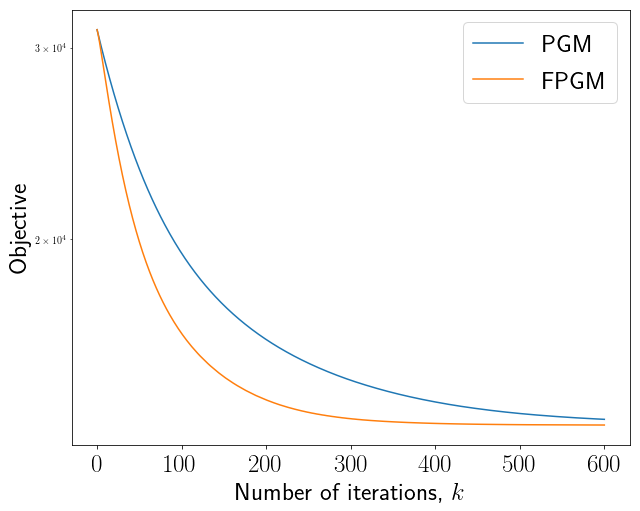

In [20]:
plt.figure(figsize=(10, 8))
fontsize=25
plt.plot([f(X) + gamma_2 * np.sum(np.abs(X[0])) + gamma_3 * np.linalg.norm(X[1], "nuc") for X in conv], label="PGM")
plt.plot([f(X) + gamma_2 * np.sum(np.abs(X[0])) + gamma_3 * np.linalg.norm(X[1], "nuc") for X in conv_acc], label="FPGM")
plt.legend(fontsize=fontsize)
plt.xlabel(r"Number of iterations, $k$", fontsize=fontsize)
plt.ylabel(r"Objective", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.yscale("log")

### Application in video processing

- Stacked matrix with frames
- Decompose it as sparse + low-rank term
- Sparse term consists of vectorized foreground part of frames
- Low-rank term consists of vectorized background part of frames

##  Further directions

1. Non-euclidean distance used as penalty, i.e. Bregman divergence and Mirror descent method 
2. Non-convex optimization
3. Parallel implementations and distributed setting
4. Use different discretization methods from ODE-related science to get new fast optimization methods, see [this paper](https://arxiv.org/pdf/1805.00521.pdf)

## References

1. [Proximal algorithms](http://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf) and related [sources](http://web.stanford.edu/~boyd/papers/prox_algs.html) by N. Parikh and S. Boyd 
2. [Gradient-based algorithms with applications to signal recovery problems](http://www.math.tau.ac.il/~teboulle/papers/gradient_chapter.pdf) by A. Beck and M. Teboulle
3. [Proximal Backpropagation](https://arxiv.org/abs/1706.04638) by T Frerix et al (ICLR 2018)
4. [Stochastic Proximal Gradient Descent with Acceleration Techniques](https://papers.nips.cc/paper/5610-stochastic-proximal-gradient-descent-with-acceleration-techniques.pdf) by A. Nitanda (NIPS 2014)

## Summary

1. Proximal method
2. Proximal map and its property
3. Proximal gradient method and its acceleration
5. Lasso application